In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import warnings
from importlib.resources import files
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from biobank_olink.clustering import (
    score_clustering, get_cluster_labels, plot_clustering,
    explain_clusters, get_embedding, to_test_cases, visualize_clustering, print_best_features
)

warnings.filterwarnings("ignore")

shap.initjs()
DATA_DIR = files("biobank_olink.data")

In [15]:
df = pd.read_csv(DATA_DIR / "olink_data_ins0.csv", index_col=0)
df

,ABCA2,ABL1,ABO,ACADM,ACE,ACHE,ACP1,ACP6,ACRBP,ACTN2,...,WWP2,XCL1,XG,XIAP,XRCC4,YAP1,YJU2,YWHAQ,ZBTB17,ZCCHC8
eid,,,,,,,,,,,,,,,,,,,,,
1000011,0.97070,1.11500,2.54650,1.9069,0.2040,0.45815,0.91650,0.26800,1.21400,0.6648,...,0.3055,1.5510,-0.1820,-0.02630,0.04460,0.59515,4.0130,2.66625,2.33585,0.54690
1000083,-0.21340,-0.35000,0.40600,-1.1517,-0.2999,0.00290,-0.40950,-1.01040,-0.30620,-0.3855,...,-0.0054,0.2938,0.0006,0.16710,-1.61140,-0.38045,0.9454,-0.07660,-0.21635,-0.04090
1000121,-0.09595,1.19470,0.50260,1.7044,0.0851,1.02915,1.93030,-0.47120,-1.22420,0.3199,...,0.3635,0.2324,0.9328,0.20580,0.41380,-0.05095,0.6031,2.14825,-0.40075,0.78220
1000366,-0.49710,0.13750,-0.39630,-0.5911,-0.0005,0.42995,0.09420,0.11370,-0.87450,0.3387,...,-0.1691,0.1383,-0.5023,-0.64980,-1.34030,0.04305,-0.5473,0.09665,-0.00145,-0.12130
1000654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.62150,NaN,NaN,...,NaN,NaN,NaN,-0.16760,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094308,0.86360,0.08820,-0.71370,-1.2876,0.0453,0.20170,-0.09180,-0.19830,0.22490,-0.5314,...,-0.2629,-0.4893,0.7391,-0.86630,0.90210,-0.40015,-1.0844,-0.72600,-0.89765,0.10600
1094405,-0.56210,-0.78550,0.49600,2.0665,0.1894,0.89875,-0.23690,0.60250,0.95810,-1.2044,...,0.3130,1.1411,0.2764,-0.03650,1.18210,0.50885,0.0260,-0.72755,2.04385,0.84530
1094553,-0.22290,-0.66640,-0.47140,-0.1338,0.0436,0.17350,0.56650,-0.44660,-0.49880,0.7642,...,0.3991,-0.4018,0.2965,1.00800,1.23870,0.81850,-1.1051,-0.41510,0.06140,0.31290


In [16]:
def print_boxplots(df):
    plt.figure(figsize=(20, 5))
    ax = sns.boxplot(data=df)
    ax.set_xticklabels([])

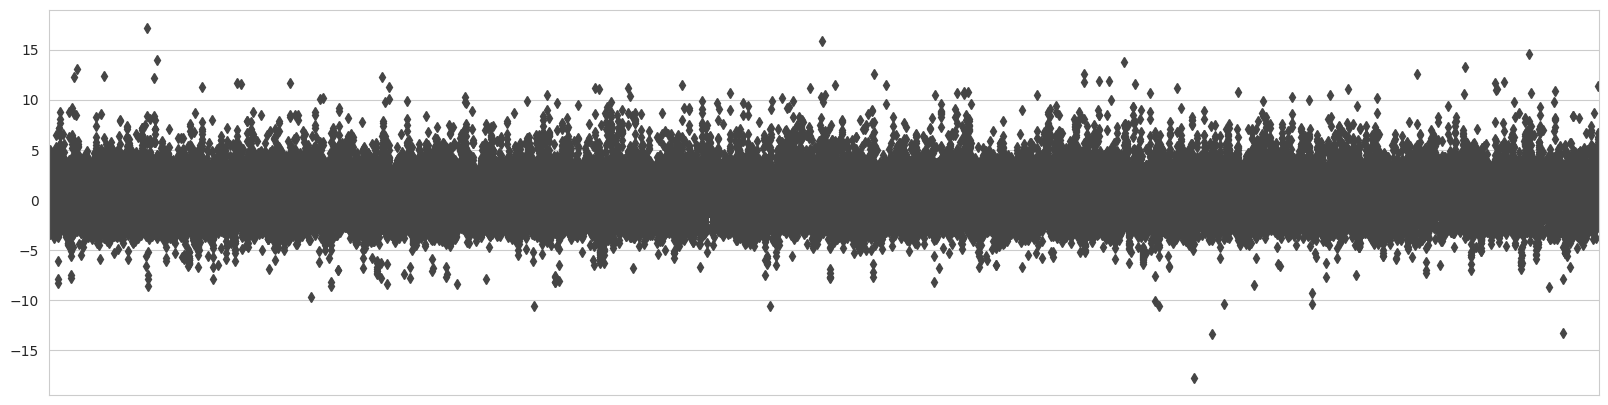

In [17]:
x = SimpleImputer(strategy="median").fit_transform(df)
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=df.columns, index=df.index)
print_boxplots(x)

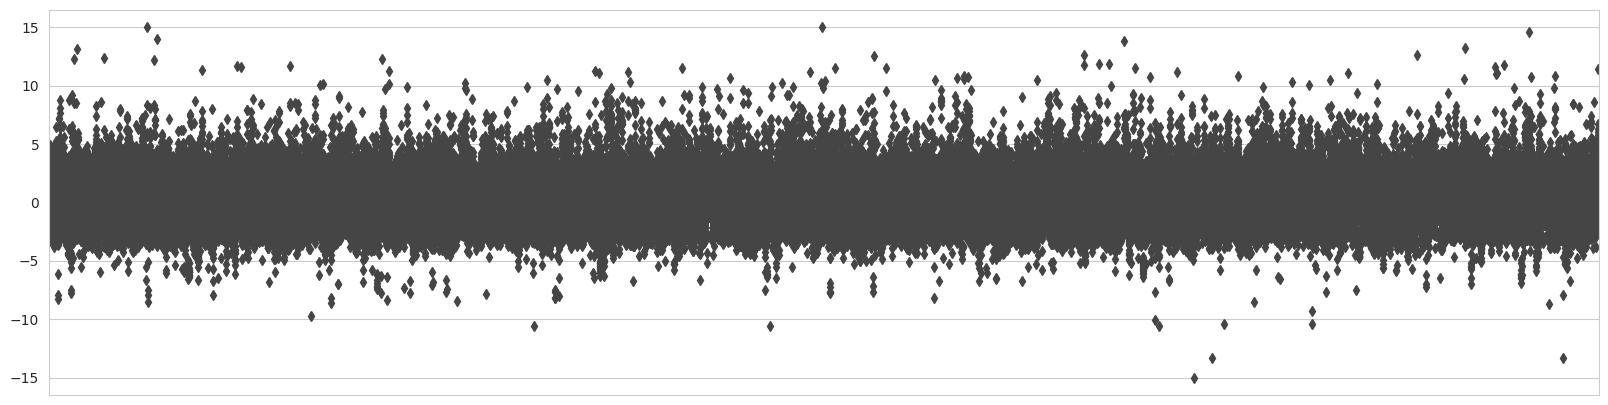

In [18]:
x.clip(lower=-15, upper=15, inplace=True)
print_boxplots(x)

In [19]:
from tqdm import tqdm

reducer_grid_spec = {
    "umap": {
        "metric": [
            "manhattan", "euclidean",
            "cosine", "correlation",
        ],
        "n_components": [2],
        "n_neighbors": [50, 100],
    },
    "tsne": {
        "n_components": [2],
        "perplexity": [15, 30, 50],
    },
    "phate": {
        "n_components": [2],
        "knn": [10, 20, 40],
        "decay": [20, 40, 60]
    }
}

clust_grid_spec = {
    "kmeans": {
        "n_clusters": [2, 3, 4, 5],
    },
    "hdbscan": {
        "min_cluster_size": [10, 30],
    },
}


def run_case(params):
    params["reducer"] = params.pop("algorithm")
    emb = get_embedding(data=x, **params)

    results = []
    for clust_param_set in to_test_cases(clust_grid_spec):
        cluster_labels = get_cluster_labels(data=emb, **clust_param_set)
        clust_param_set["clust_alg"] = clust_param_set.pop("algorithm")

        score = score_clustering(emb, cluster_labels)
        results.append({
            **score,
            **params,
            **clust_param_set
        })
    return results


results = Parallel(n_jobs=2)(
    delayed(run_case)(params) for params in tqdm(to_test_cases(reducer_grid_spec)))



  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 4/20 [00:17<01:09,  4.32s/it]

 30%|███       | 6/20 [00:22<00:49,  3.56s/it]

 40%|████      | 8/20 [00:28<00:39,  3.31s/it]

 50%|█████     | 10/20 [00:34<00:33,  3.34s/it]

 60%|██████    | 12/20 [00:42<00:27,  3.43s/it]

 70%|███████   | 14/20 [00:50<00:21,  3.64s/it]

 80%|████████  | 16/20 [00:54<00:12,  3.12s/it]

 90%|█████████ | 18/20 [00:57<00:05,  2.64s/it]

100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


In [20]:
score_df = pd.DataFrame.from_records(chain.from_iterable(results))
score_df = score_df.sort_values(by="silhouette", ascending=False).reset_index(drop=True)
score_df.head(20)

,silhouette,calinski_harabasz,davies_bouldin,label_counts,metric,n_components,n_neighbors,reducer,n_clusters,clust_alg,min_cluster_size,perplexity,knn,decay
0,0.737485,5700.132488,0.362918,"[582, 418]",correlation,2,100.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
1,0.737331,5685.154323,0.362254,"[584, 416]",correlation,2,100.0,umap,NaN,hdbscan,10.0,NaN,NaN,NaN
2,0.736586,5813.714966,0.362435,"[564, 436]",correlation,2,50.0,umap,NaN,hdbscan,10.0,NaN,NaN,NaN
3,0.736586,5813.714966,0.362435,"[564, 436]",correlation,2,50.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
4,0.573117,2003.290577,0.644311,"[489, 511]",cosine,2,50.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
5,0.561752,1874.552740,0.666780,"[495, 505]",cosine,2,100.0,umap,2.0,kmeans,NaN,NaN,NaN,NaN
6,0.561474,3442.657029,0.785848,"[564, 227, 209]",correlation,2,50.0,umap,3.0,kmeans,NaN,NaN,NaN,NaN
7,0.548295,2049.372263,0.617315,"[569, 431]",NaN,2,NaN,phate,2.0,kmeans,NaN,NaN,40.0,20.0
8,0.544165,2038.805752,0.659416,"[446, 356, 198]",cosine,2,50.0,umap,3.0,kmeans,NaN,NaN,NaN,NaN
9,0.536870,1921.306714,0.637509,"[582, 418]",NaN,2,NaN,phate,2.0,kmeans,NaN,NaN,40.0,40.0


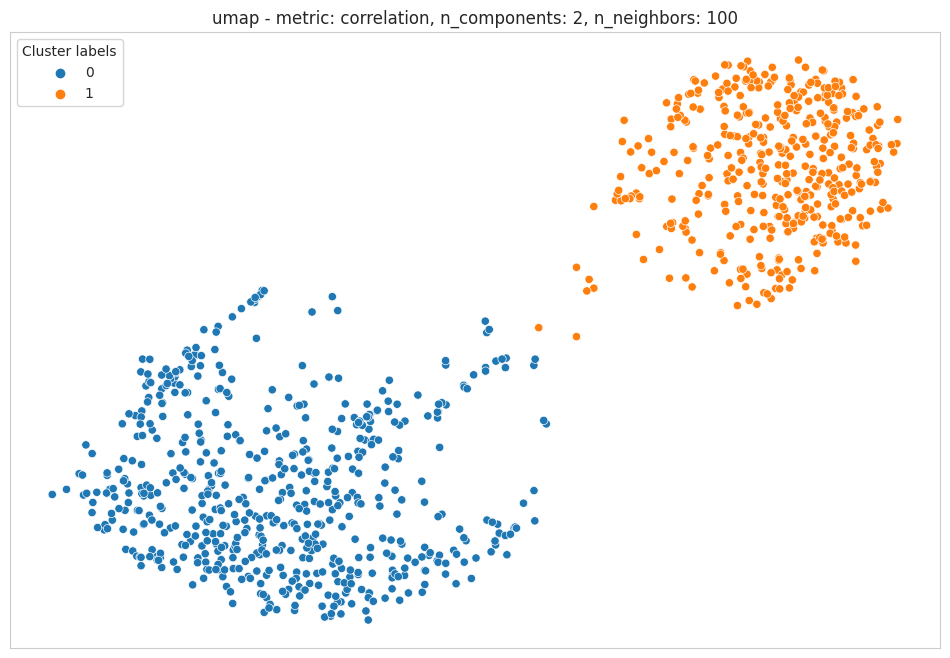

In [22]:
n = 0
params = score_df.iloc[n].to_dict()
reducer = params["reducer"]
reducer_params = {k: int(v) if isinstance(v, float) else v for k, v in params.items() if
                  k in reducer_grid_spec[reducer]}

embedding = get_embedding(data=x, reducer=reducer, **reducer_params)

clust_alg = params["clust_alg"]
clust_alg_params = {k: int(v) for k, v in params.items() if k in clust_grid_spec[clust_alg]}
cluster_labels = get_cluster_labels(embedding, algorithm=clust_alg, **clust_alg_params)
cluster_labels.name = "Cluster labels"

if params["n_components"] == 2:
    title = f"{reducer} - " + ", ".join([f"{k}: {v}" for k, v in reducer_params.items()])
    ax = plot_clustering(embedding, cluster_labels, title=title)

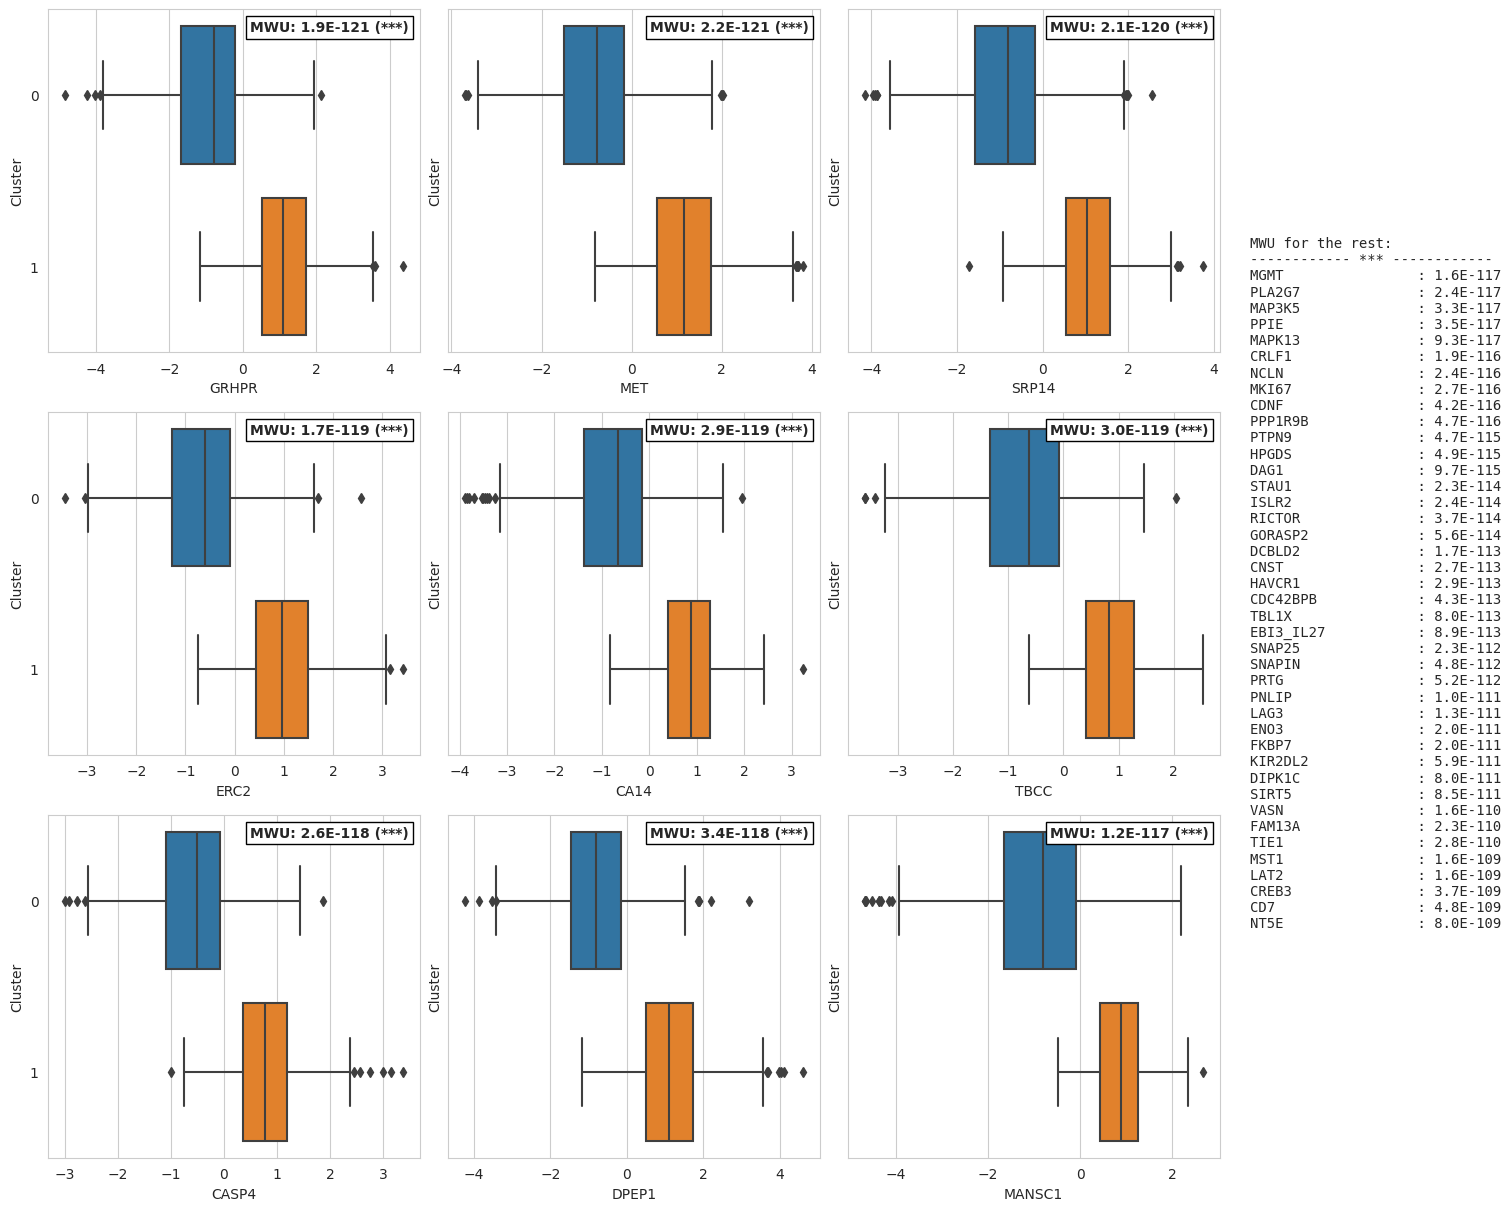

In [23]:
col_pvals = print_best_features(cluster_labels, df)

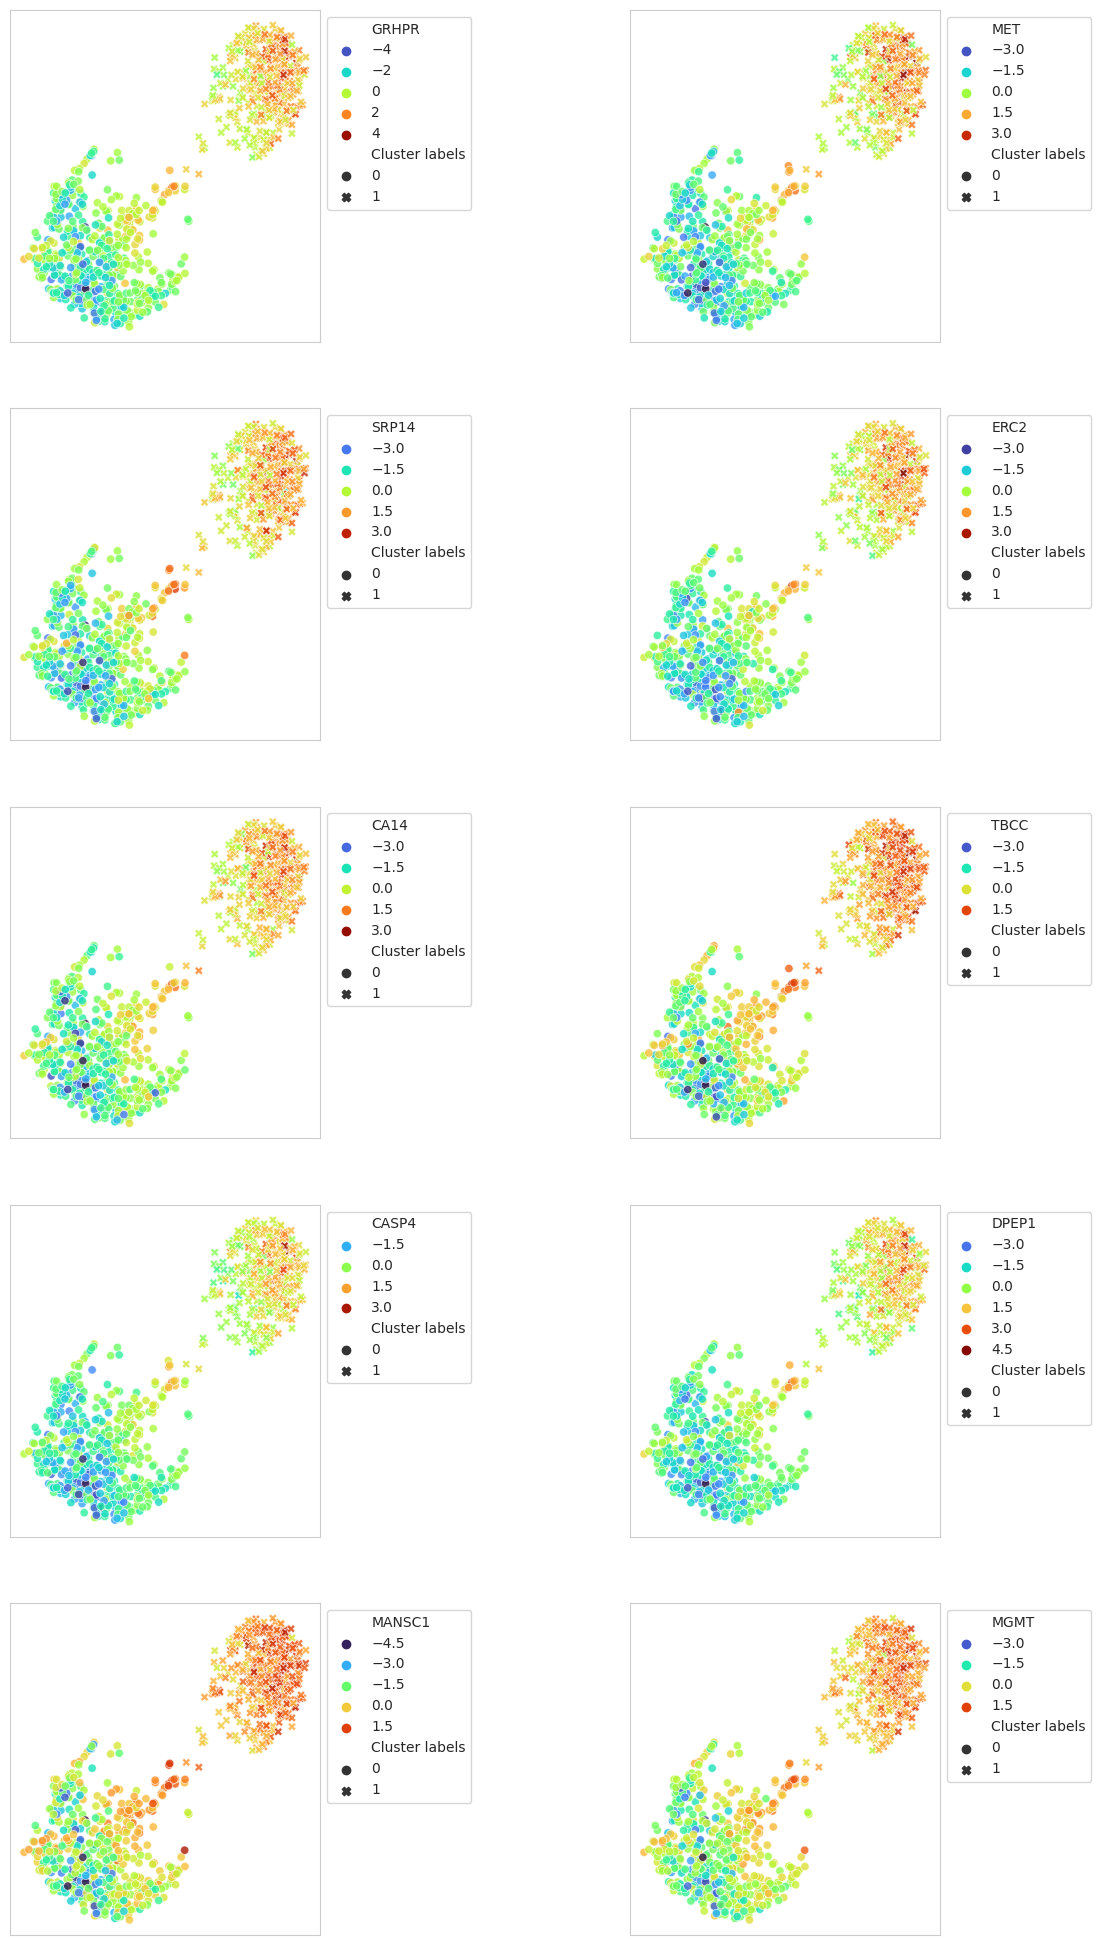

In [24]:
visualize_clustering(embedding, df[[col for col, _ in col_pvals[:10]]].reset_index(drop=True),
                     cluster_labels)

Explanation accuracy: 0.984


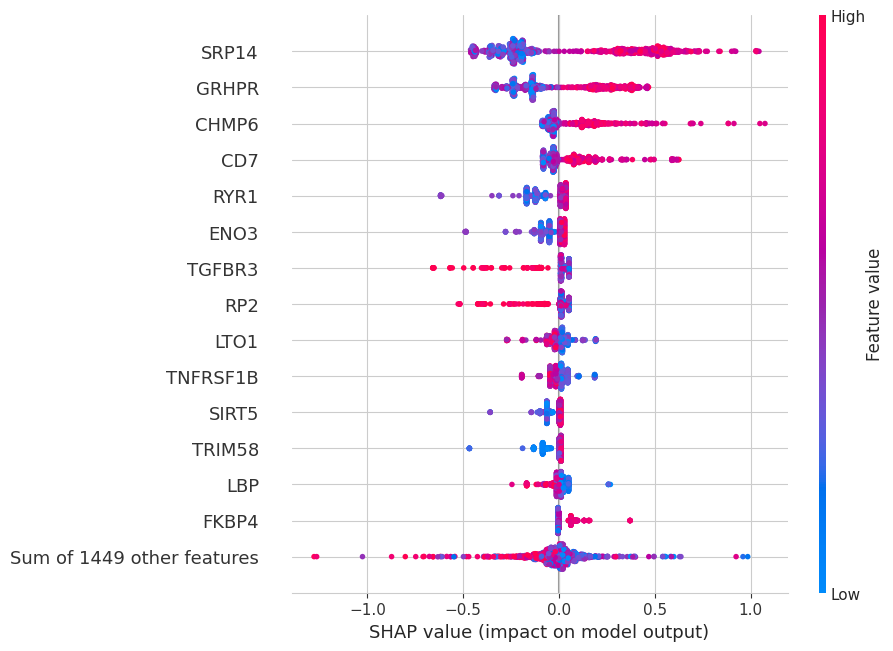

In [26]:
explain_clusters(cluster_labels, x=x, x_orig=df,
                 xgb_params=dict(n_estimators=2, max_depth=6),
                 max_display=15)